In [1]:
# !pip install tensorflow
# !pip install tensorboard

## Word Embeddings

* https://www.tensorflow.org/text/guide/word_embeddings?hl=ko

* 임베딩 프로젝터 : [링크](https://projector.tensorflow.org/?hl=ko&_gl=1*qcvijm*_ga*ODk4NzAxOTgzLjE3MDExNjQyNzM.*_ga_W0YLR4190T*MTcwMTgzNzYzMy42LjEuMTcwMTgzODU2Mi4wLjAuMA..)

[tensorflow/text: Making text a first-class citizen in TensorFlow.](https://github.com/tensorflow/text/tree/master)

In [2]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

## 예시 코퍼스

In [3]:
# 음식 리뷰 예제 텍스트 데이터
corpus = [
    "Salad 맛이 깔끔해서 좋아요.",
    "주문한 음식이 늦게 와서 배고팠어요.",
    "Pizza가 맛있어요.",
    "라면이 너무 짜게 나왔어요.",
    "배달된 치킨이 맛있어요.",
    "메뉴 설명보다 양이 적어요.",
    "주문한 음식이 다른 것으로 와서 다시 주문했어요.",
    "맛은 좋은데 양이 좀 적은 편이에요.",
    "떡볶이의 매운맛이 적절해요.",
    "초밥이 신선해서 좋았어요.",
    "빵이 부드럽고 맛있네요!",
    "스테이크가 너무 질겼어요.",
    "샐러드의 드레싱이 너무 강했어요.",
    "나초의 치즈소스가 맛있었어요.",
    "파스타가 약간 덜 익은 것 같아요.",
    "커피가 너무 진해서 물을 더 추가했어요.",
    "디저트는 달지 않아서 좋았습니다.",
    "음료가 너무 달아서 다음엔 당도 조절할게요.",
    "피자 도우가 너무 두꺼워서 먹기 힘들었어요.",
    "피자가 맛 없어요.",
    "햄버거의 빵이 너무 딱딱해요.",
    "감자튀김이 너무 기름져서 느끼했어요.",
    "치즈케이크가 아주 부드럽고 맛있어요."
]
labels = [1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]
labels

[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1]

In [4]:
# DataFrame
df = pd.DataFrame(corpus, columns=["문서"])
df["긍정부정"] = labels
df

,문서,긍정부정
0,Salad 맛이 깔끔해서 좋아요.,1
1,주문한 음식이 늦게 와서 배고팠어요.,0
2,Pizza가 맛있어요.,1
3,라면이 너무 짜게 나왔어요.,0
4,배달된 치킨이 맛있어요.,1
5,메뉴 설명보다 양이 적어요.,0
6,주문한 음식이 다른 것으로 와서 다시 주문했어요.,0
7,맛은 좋은데 양이 좀 적은 편이에요.,0
8,떡볶이의 매운맛이 적절해요.,1
9,초밥이 신선해서 좋았어요.,1


## TextVectorization
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [5]:
# tensorflow
# TextVectorization, Embedding, GlobalAveragePooling1D
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAvgPool1D

2023-12-09 22:21:48.673554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [7]:
# 소문자 변환: 입력된 텍스트를 모두 소문자로 변경합니다.
# HTML 태그 제거: HTML 태그(<br />)를 공백으로 대체합니다.
# 구두점 제거: 모든 구두점을 제거합니다.

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')

* max_tokens: 텍스트에서 고려할 최대 토큰 수를 지정합니다. 가장 빈도가 높은 max_tokens 개의 토큰만 사용됩니다.
* standardize: 텍스트를 표준화하는 방법을 선택합니다. 'lower_and_strip_punctuation'로 설정하면 소문자로 변환하고 문장부호를 제거합니다.
* split: 텍스트를 토큰화하는 방법을 선택합니다. 'whitespace'로 설정하면 공백을 기준으로 텍스트가 토큰화됩니다.
* ngrams: 단일 토큰 이상의 n-그램을 생성하도록 지정합니다. 예를 들어, ngrams=2로 설정하면 바이그램이 생성됩니다.
* output_mode: 출력 모드를 지정합니다. 'int'로 설정하면 정수로 변환된 토큰이 출력됩니다.
* output_sequence_length: 출력 시퀀스의 길이를 지정합니다. 이 매개변수를 사용하여 모든 시퀀스를 고정된 길이로 패딩하거나 자를 수 있습니다.
* pad_to_max_tokens: True로 설정하면 max_tokens으로 시퀀스를 패딩합니다.
* vocabulary: 사용할 어휘 사전을 지정합니다. 사전이 제공되면 모델은 이 사전에 있는 토큰만 고려합니다.
* sparse: True로 설정하면 희소 텐서를 출력합니다.
* ragged: True로 설정하면 불규칙한 길이의 토큰을 나타내는 tf.RaggedTensor를 출력합니다.
* encoding: 텍스트의 인코딩을 지정합니다.
* kwargs: 기타 설정을 위한 추가적인 키워드 인수를 받습니다.

In [8]:
df

,문서,긍정부정
0,Salad 맛이 깔끔해서 좋아요.,1
1,주문한 음식이 늦게 와서 배고팠어요.,0
2,Pizza가 맛있어요.,1
3,라면이 너무 짜게 나왔어요.,0
4,배달된 치킨이 맛있어요.,1
5,메뉴 설명보다 양이 적어요.,0
6,주문한 음식이 다른 것으로 와서 다시 주문했어요.,0
7,맛은 좋은데 양이 좀 적은 편이에요.,0
8,떡볶이의 매운맛이 적절해요.,1
9,초밥이 신선해서 좋았어요.,1


In [9]:
# TextVectorization 레이어 설정
# standardize, max_tokens, output_mode
VOCAB_SIZE = 100
MAX_SEQUENCE_LENGTH = 10

vectorizer = TextVectorization(standardize=custom_standardization, 
                              max_tokens=VOCAB_SIZE, 
                              output_sequence_length=MAX_SEQUENCE_LENGTH)
vectorizer.adapt(corpus)

In [10]:
vocab = vectorizer.get_vocabulary()[:10]
vocab

['', '[UNK]', '너무', '맛있어요', '주문한', '음식이', '와서', '양이', '빵이', '부드럽고']

In [11]:
corpus[:4]

['Salad 맛이 깔끔해서 좋아요.',
 '주문한 음식이 늦게 와서 배고팠어요.',
 'Pizza가 맛있어요.',
 '라면이 너무 짜게 나왔어요.']

In [12]:
vocab[4], vocab[5]

('주문한', '음식이')

In [13]:
# df_vect
vectorizer_corpus = vectorizer(corpus)
df_vect = pd.DataFrame(vectorizer_corpus)
df_vect

,0,1,2,3,4,5,6,7,8,9
0,82,53,75,29,0,0,0,0,0,0
1,4,5,71,6,46,0,0,0,0,0
2,83,3,0,0,0,0,0,0,0,0
3,56,2,22,74,0,0,0,0,0,0
4,45,17,3,0,0,0,0,0,0,0
5,48,43,7,34,0,0,0,0,0,0
6,4,5,70,77,6,69,25,0,0,0
7,54,26,7,30,33,14,0,0,0,0
8,57,50,32,0,0,0,0,0,0,0
9,21,41,27,0,0,0,0,0,0,0


## 벡터화 결과 시각화

In [14]:
# df_vect.replace(0, np.nan).isnull()

<Axes: >

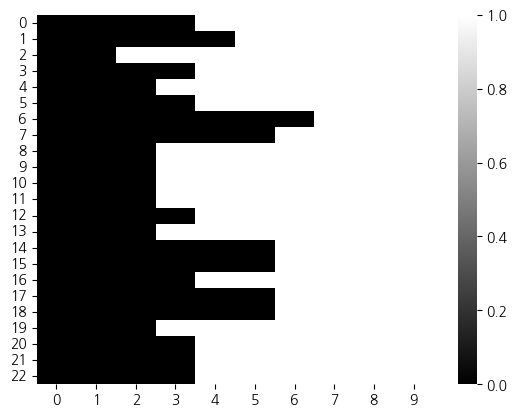

In [15]:
# sns.heatmap
sns.heatmap(df_vect.replace(0, np.nan).isnull(), cmap="gray")

<Axes: >

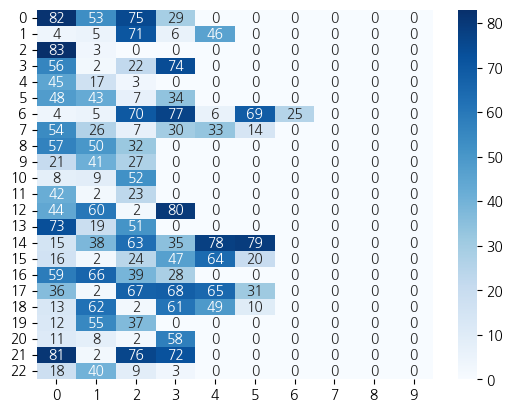

In [16]:
# sns.heatmap
sns.heatmap(df_vect, annot=True, cmap="Blues")

## 원래 텍스트로 복원하기

encoder.get_vocabulary() 메서드를 사용할 때 TextVectorization 레이어는 일반적으로 어휘 목록을 빈도 순으로 정렬합니다. 즉, 코퍼스에서 가장 자주 나타나는 단어가 목록의 상위에 위치하게 됩니다. 이렇게 하는 이유는 빈도가 높은 단어들이 데이터에서 더 중요하거나 유용할 가능성이 높기 때문입니다.

그러나 이 목록에는 일반적으로 몇 가지 예약된 토큰들이 포함되어 있습니다. 예를 들어, [UNK] (알 수 없는 단어를 나타내는 토큰), [PAD] (패딩을 위한 토큰) 등이 이에 해당합니다. 이러한 예약된 토큰들은 목록의 최상위에 위치합니다.

어휘 목록의 정렬 순서는 TextVectorization 레이어의 설정에 따라 달라질 수 있으며, 필요에 따라 사용자가 이를 커스터마이징할 수도 있습니다. 예를 들어, 토큰화 방식, 텍스트 표준화 방법, 최대 토큰 수 등의 설정을 변경하여 어휘 목록의 생성 방식을 조정할 수 있습니다.

In [17]:
vocabulary = vectorizer.get_vocabulary()
vocabulary[:10]

['', '[UNK]', '너무', '맛있어요', '주문한', '음식이', '와서', '양이', '빵이', '부드럽고']

In [18]:
# 반복문으로 어휘의 짝을 찾아보기 
for num in df_vect.iloc[0]:
    print(vocabulary[num], end=" ")

salad 맛이 깔끔해서 좋아요       

## 다른 텍스트에 적용하기

In [19]:
new_corpus = [
    "샌드위치가 신선한 재료로 만들어져서 좋았어요.",
    "햄버거의 패티가 매우 맛있어요.",
    "주문한 스시가 빨리 도착해서 만족스러웠어요.",
    "라멘의 국물이 너무 매워서 못 먹었어요.",
    "배달된 파스타가 따뜻해서 좋았어요.",
    "주문한 샐러드가 늦게 와서 아쉬웠어요.",
    "케이크의 크림이 너무 달지 않아서 좋았어요.",
    "샌드위치의 빵이 너무 딱딱해서 먹기 어려웠어요.",
    "피자의 토핑이 푸짐해서 좋았어요.",
    "불고기가 너무 질겨서 실망했어요."
]

In [20]:
vectorizer(new_corpus)

<tf.Tensor: shape=(10, 10), dtype=int64, numpy=
array([[ 1,  1,  1,  1, 27,  0,  0,  0,  0,  0],
       [11,  1,  1,  3,  0,  0,  0,  0,  0,  0],
       [ 4,  1,  1,  1,  1,  0,  0,  0,  0,  0],
       [ 1,  1,  2,  1,  1,  1,  0,  0,  0,  0],
       [45, 15,  1, 27,  0,  0,  0,  0,  0,  0],
       [ 4,  1, 71,  6,  1,  0,  0,  0,  0,  0],
       [ 1,  1,  2, 66, 39, 27,  0,  0,  0,  0],
       [ 1,  8,  2,  1, 49,  1,  0,  0,  0,  0],
       [ 1,  1,  1, 27,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  1,  0,  0,  0,  0,  0,  0]])>

## 임베딩하고 시각화 하기
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* 시각화 했을 때 너무 겹쳐 보이지 않게 하기 위해 적은양의 텍스트로 실습합니다.

In [21]:
# 임베딩 레이어 생성
embedding_dim = 4
embedding_layer = Embedding(input_dim=100, output_dim=embedding_dim)
embedding_layer

In [22]:
short_corpus = ["피자가 맛있어요.", 
              "햄버거가 맛있어요.", 
              "치킨이 맛있어요", 
              "피자가 맛없어요.",
              "햄버거가 맛없어요.", 
              "치킨이 맛없어요", ]

# 텍스트를 벡터화하고 임베딩 적용
vectorized_texts = vectorizer(short_corpus)
embeddings = embedding_layer(vectorized_texts)

In [23]:
# shape (문장의 수, 각 문장의 최대 길이, 임베딩 차원)
vectorized_texts.shape, embeddings.shape

(TensorShape([6, 10]), TensorShape([6, 10, 4]))

## 차원축소로 시각화 하기

In [24]:
from tensorflow.keras.layers import GlobalAveragePooling1D
# 차원축소를 위해 dim 3 => dim => 2 로 줄이기
# GlobalAveragePooling1D 레이어 추가
pooling_layer = GlobalAveragePooling1D()

# 각 문장에 대한 임베딩의 평균 계산
average_embeddings = pooling_layer(embeddings)
average_embeddings

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[ 0.01675782,  0.027034  , -0.02147168, -0.03378123],
       [ 0.01101944,  0.02282492, -0.01759885, -0.0271598 ],
       [ 0.01157174,  0.02430947, -0.02246631, -0.02824588],
       [ 0.01471905,  0.01867659, -0.02163013, -0.03356628],
       [ 0.00898067,  0.01446751, -0.01775729, -0.02694485],
       [ 0.00953297,  0.01595205, -0.02262475, -0.02803093]],
      dtype=float32)>

In [25]:
from sklearn.manifold import TSNE

# t-SNE를 사용한 차원 축소
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
reduced_embeddings = tsne.fit_transform(average_embeddings)
reduced_embeddings

array([[ -56.48057   ,   75.48894   ],
       [  75.050545  ,   20.996138  ],
       [  25.346807  ,   49.34595   ],
       [ -56.171974  ,  -18.02028   ],
       [  55.58583   , -106.00941   ],
       [   0.86041415,  -82.85081   ]], dtype=float32)

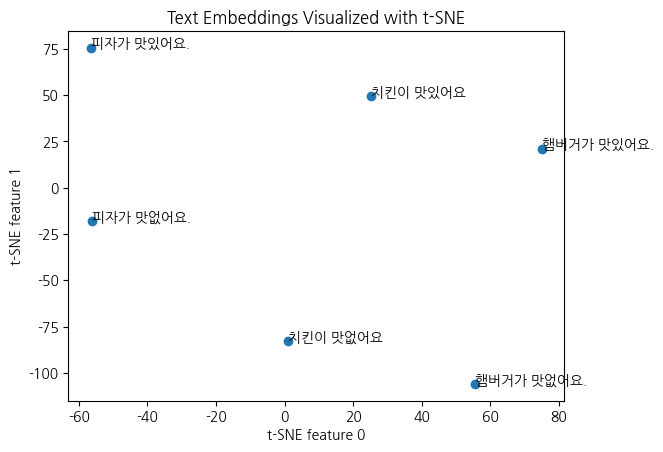

In [26]:
# 시각화
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
for i, text in enumerate(short_corpus):
    plt.annotate(text, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.title('Text Embeddings Visualized with t-SNE')
plt.show()

## Sequential

* TextVectorization 레이어는 문자열을 어휘 인덱스로 변환합니다.
* TextVectorization으로 변환된 문자열을 Embedding 계층에 공급할 수 있습니다.
* Embedding 레이어는 정수로 인코딩된 어휘를 취하고 각 단어 인덱스에 대한 임베딩 벡터를 찾습니다. 
* 이러한 벡터는 모델이 학습될 때 학습됩니다. 
* 벡터는 출력 배열에 차원을 추가합니다. 결과 차원은 (batch, sequence, embedding) 입니다.
* GlobalAveragePooling1D 계층은 시퀀스 차원을 평균화하여 각 예제에 대해 고정 길이 출력 벡터를 반환합니다. 이를 통해 모델은 가능한 가장 간단한 방법으로 가변 길이의 입력을 처리할 수 있습니다.
* 고정 길이 출력 벡터는 16개의 은닉 유닛이 있는 완전 연결( Dense ) 레이어를 통해 연결됩니다.
* 마지막 레이어는 단일 출력 노드와 조밀하게 연결됩니다.


In [27]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# embedding_dim = 16

# Sequential
model = Sequential([embedding_layer, 
                    GlobalAveragePooling1D(), 
                    Dense(units=16, activation="relu"),
                    Dense(1)
                   ])
model

## summary

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           400       
                                                                 
 global_average_pooling1d_1  (None, 4)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## compile

* model.compile은 TensorFlow 모델을 컴파일하는 메서드로, 모델의 학습 과정을 설정합니다. 
* optimizer: 옵티마이저를 지정합니다. 'adam'은 Adam 옵티마이저를 사용하겠다는 것을 의미합니다. Adam은 경사 하강법의 한 종류로, 학습 속도를 동적으로 조절하여 효율적인 최적화를 수행하는 알고리즘입니다.
* loss: 손실 함수를 지정합니다. tf.keras.losses.BinaryCrossentropy는 이진 분류 문제를 위한 크로스 엔트로피 손실 함수입니다. from_logits=True는 모델의 출력이 로짓(확률이 아닌 모델의 선형 출력)으로 제공되며, 이를 확률로 변환하여 손실을 계산하겠다는 의미입니다.
* metrics: 모델의 성능을 평가할 지표를 지정합니다. 여기서는 'accuracy'만 사용되었으며, 이는 모델의 정확도를 평가하는 지표입니다.

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [30]:
# model.compile
# y = ax + b
model.compile(optimizer="adam", 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=["accuracy"])

## fit

* model.fit은 TensorFlow 모델을 학습시키는 메서드입니다.
* x: 모델의 입력 데이터를 지정합니다. 시험의 기출문제인 x_train 을 지정합니다.
* y: 모델의 정답값(label)을 지정합니다.
* epochs: 전체 데이터셋에 대해 학습을 반복하는 횟수를 지정합니다.
* callbacks: 학습 중에 호출되는 콜백 함수들의 리스트를 지정합니다. 
* model.fit을 호출하면 모델은 주어진 데이터셋과 목표값을 사용하여 지정된 에포크 수만큼 학습을 진행합니다. 각 에포크마다 모델의 가중치가 조정되며, 손실 함수를 최소화하는 방향으로 학습이 이루어집니다. 
* TensorBoard 콜백을 사용하면 학습 과정을 모니터링하고 시각화할 수 있습니다.
* https://www.tensorflow.org/tensorboard/get_started?hl=ko

In [ ]:
# Clear any logs from previous runs
# 아래 명령어가 운영체제 문제로 동작하지 않는다면 폴더위치에 가서 삭제해 주어도 됩니다.
# !rm -rf ./logs/

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [31]:
vectorizer_corpus.shape, np.array(labels).shape

(TensorShape([23, 10]), (23,))

In [32]:
# for tensorboard Clear any logs from previous runs
!rm -rf ./logs/

In [43]:
# model.fit
model.fit(x=vectorizer_corpus, y=np.array(labels), epochs=100, 
    callbacks=[tensorboard_callback])

Epoch 1/100
1/1 [==============================] - 0s 28ms/step - loss: 0.6037 - accuracy: 0.6087
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6020 - accuracy: 0.6087
Epoch 3/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6004 - accuracy: 0.6087
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.5987 - accuracy: 0.6087
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.5970 - accuracy: 0.6087
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5953 - accuracy: 0.6087
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.5935 - accuracy: 0.6087
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.5918 - accuracy: 0.6087
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5901 - accuracy: 0.6087
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 0.5883 - accuracy: 0.6087
Epoch 11/100
1/1 [=

## tensorboard
* https://www.tensorflow.org/get_started/summaries_and_tensorboard

In [46]:
# docs_infra: no_execute
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## visualize_the_embeddings

* https://www.tensorflow.org/text/guide/word_embeddings?hl=ko#visualize_the_embeddings

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           400       
                                                                 
 global_average_pooling1d_1  (None, 4)                 0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# No such layer: embedding. Existing layers are: ['embedding_2', 등의 메시지가 나온다면
# 컴파일을 여러번 해서 그렇습니다. embedding_2 등으로 변경해 주거나 해당 주피터 노트북의 커널 메뉴에서 재시작을 해주시면 됩니다.
# weights
# vocab
weights = model.get_layer("embedding").get_weights()[0]
vocab = vectorizer.get_vocabulary()

In [37]:
# columns=['word'] 로 데이터프레임을 생성 
# 가장 첫 데이터는 패딩으로 이후 데이터 부터 사용
# 파일로 저장 : "metadata.tsv",  sep="\t", index=False, header=False
df_vocab = pd.DataFrame(vocab[1:], columns=["word"])
df_vocab.to_csv("metadata.tsv", sep="\t", index=False, header=False)
pd.read_csv("metadata.tsv", sep="\t")

,[UNK]
0,너무
1,맛있어요
2,주문한
3,음식이
4,와서
...,...
77,같아요
78,강했어요
79,감자튀김이
80,salad


In [38]:
# "vectors.tsv"
# index=False, header=False 로 저장
df_w = pd.DataFrame(weights[1:len(vocab)])
df_w.to_csv("vectors.tsv", sep="\t", index=False, header=False)
pd.read_csv("vectors.tsv", sep="\t")

,-0.042667903,-0.04853275,0.019147303,0.021409761
0,0.141308,0.123149,-0.129947,-0.118388
1,-0.144288,-0.082949,0.145169,0.147159
2,0.166320,0.097318,-0.087067,-0.080207
3,0.072453,0.068829,-0.148653,-0.142139
4,0.071517,0.154308,-0.146167,-0.074678
...,...,...,...,...
77,0.126403,0.159853,-0.148593,-0.121677
78,0.166985,0.104194,-0.140893,-0.086625
79,0.073908,0.099187,-0.140462,-0.142638
80,-0.107122,-0.091469,0.088074,0.138564


* 임베딩 프로젝터 : [링크](https://projector.tensorflow.org/?hl=ko&_gl=1*qcvijm*_ga*ODk4NzAxOTgzLjE3MDExNjQyNzM.*_ga_W0YLR4190T*MTcwMTgzNzYzMy42LjEuMTcwMTgzODU2Mi4wLjAuMA..)

In [39]:
# colab 사용시 파일 다운로드
# try:
#     from google.colab import files
#     files.download('vectors.tsv')
#     files.download('metadata.tsv')
# except Exception:
#     pass